# Nregions Inference
#### Following on from Multifrequency code and Anstey FG regions Model, we are now interested in bringing it all together to infer the 21-cm foregrounds using the Anstey model.

In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import svd
import pandas as pd
import seaborn as sns

from pygdsm import GlobalSkyModel2016

import src.forward_model as FM
import src.beam_functions as BF
import src.powerlaw_regression as PR
import src.sky_models as SM
import src.spherical_harmonics as SH
from src.blockmat import BlockMatrix, BlockVector
from src.spherical_harmonics import RealSphericalHarmonics
RS = RealSphericalHarmonics()

from chainconsumer import ChainConsumer

In [2]:
# Forward model the fiducial degraded GSMA.
Nfreq = 51
nuarr = np.linspace(50,100,51)
lmax = 32
nside = 16
npix = hp.nside2npix(nside)
narrow_cosbeam = lambda x: BF.beam_cos(x, theta0=0.8)
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax)

#mat_A, (mat_G, mat_Y, mat_B) = FM.calc_observation_matrix_all_pix_multifreq(nuarr, nside, lmax, Ntau=npix, beam_use=narrow_cosbeam, return_mat=True)
times = np.linspace(0,24,24, endpoint=False)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_multifreq(nuarr, nside, lmax, Ntau=len(times), times=times, beam_use=narrow_cosbeam, return_mat=True)

d = mat_A@fg_alm
dnoisy, noise_covar = SM.add_noise(temps=d, dnu=1, Ntau=npix, t_int=1e4)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


3072 561


In [14]:
model_3 = NRI.main(Nregions=3, return_model=True)


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


3072 561
[2.46303511 2.66229307 2.86155103 3.06080899]
[[2.46303511 2.66229307]
 [2.66229307 2.86155103]
 [2.86155103 3.06080899]]


In [3]:
import nregions_inference as NRI
model_3 = NRI.main(Nregions=3, return_model=True)
model_4 = NRI.main(Nregions=4, return_model=True)
model_5 = NRI.main(Nregions=5, return_model=True)


3072 561
[2.46303511 2.58258988 2.70214466 2.82169944 2.94125421 3.06080899]
[[2.46303511 2.58258988]
 [2.58258988 2.70214466]
 [2.70214466 2.82169944]
 [2.82169944 2.94125421]
 [2.94125421 3.06080899]]
3072 561
[2.46303511 2.61247858 2.76192205 2.91136552 3.06080899]
[[2.46303511 2.61247858]
 [2.61247858 2.76192205]
 [2.76192205 2.91136552]
 [2.91136552 3.06080899]]


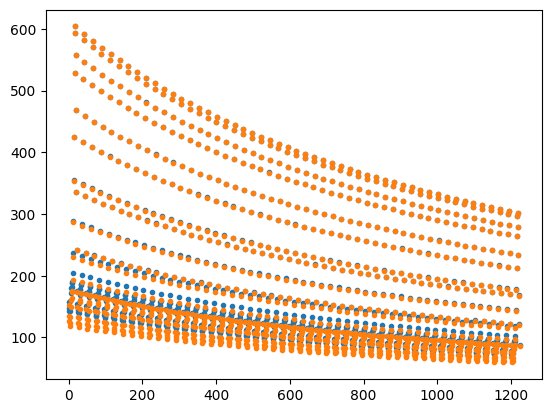

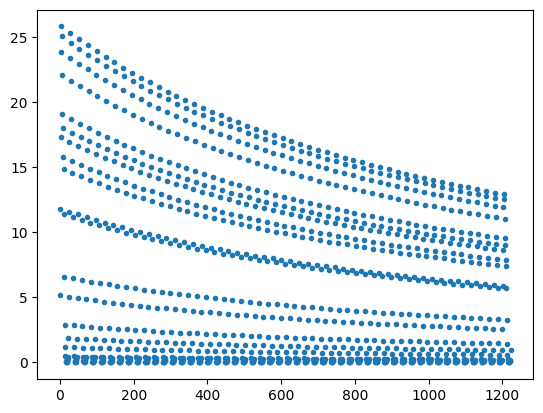

In [17]:
plt.plot(model_3(theta=[1, 1, 1]), '.')
plt.plot(model_4(theta=[1, 1, 1,  -10000000011]), '.')
plt.show()
plt.plot(model_3(theta=[1, 1, 1])-model_4(theta=[1, 1, 1, -10000000000011]), '.')

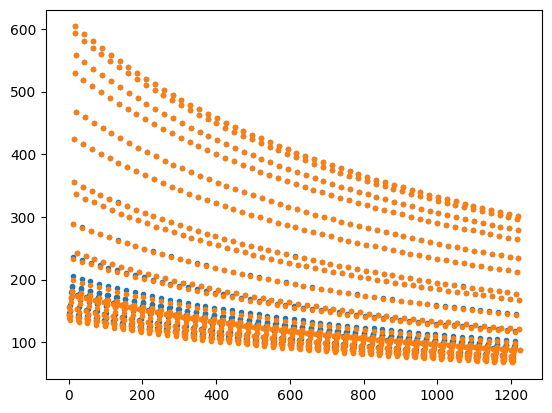

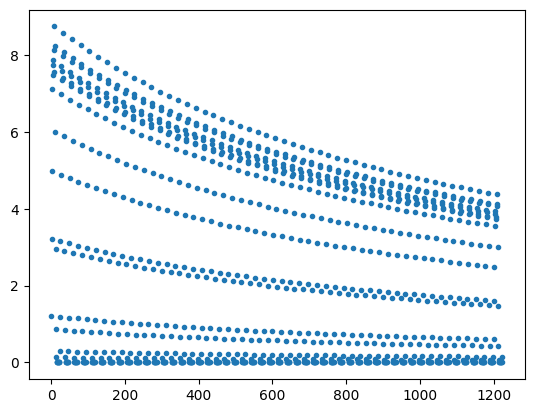

In [13]:
plt.plot(model_4(theta=[1, 1, 1, 1]), '.')
plt.plot(model_5(theta=[1, 1, 1, 1, -111]), '.')
plt.show()
plt.plot(model_4(theta=[1, 1, 1, 1])-model_5(theta=[1, 1, 1, 1, -10000000011]), '.')

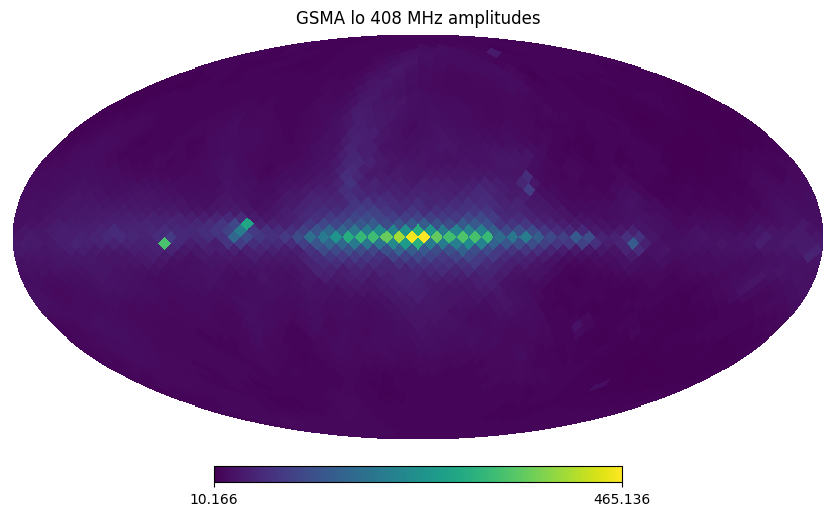

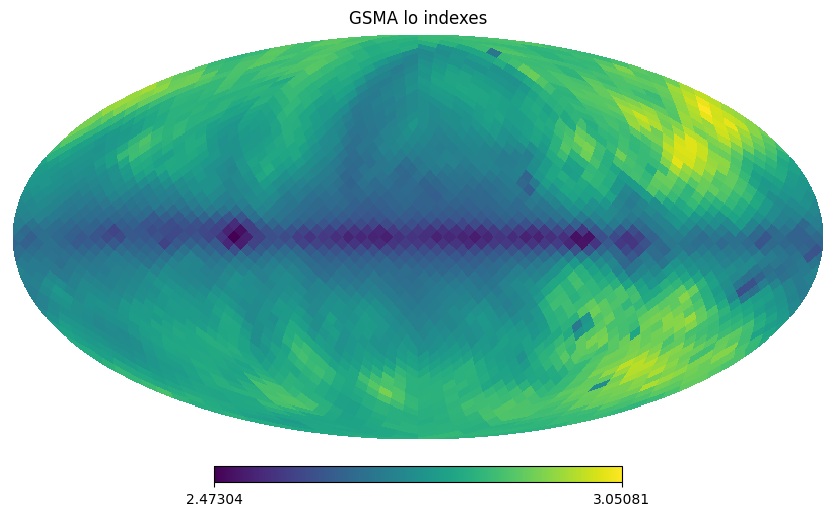

[2.46303511 2.61247858 2.76192205 2.91136552 3.06080899]
[[2.46303511 2.61247858]
 [2.61247858 2.76192205]
 [2.76192205 2.91136552]
 [2.91136552 3.06080899]]


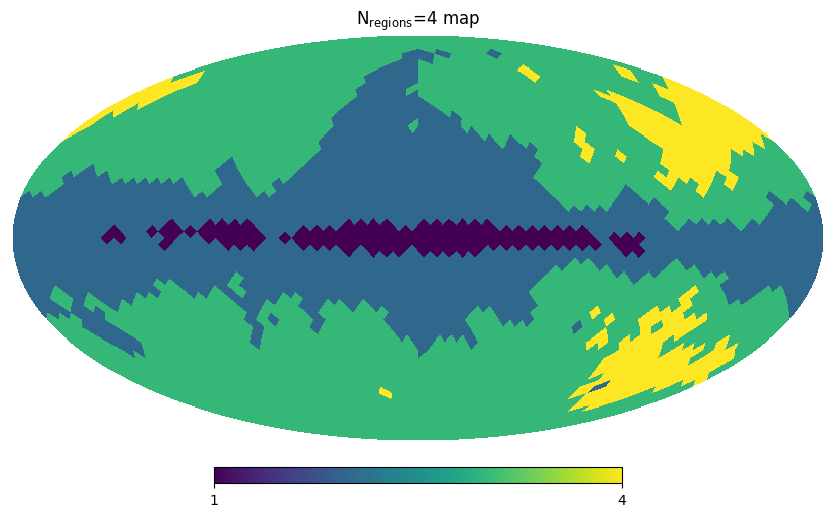

In [8]:
# Split the sky into the Nregions.
indx = np.load("anstey/indexes_16.npy")
hp.mollview(indx[0], title="GSMA lo 408 MHz amplitudes")
plt.show()
hp.mollview(indx[1], title="GSMA lo indexes")
plt.show()

Nregions = 4
max_indx = np.max(indx[1])+0.01
min_indx = np.min(indx[1])-0.01
indx_range = np.linspace(min_indx, max_indx, Nregions+1)
inference_bounds = [(indx_range[i],indx_range[i+1]) for i in range(Nregions)]
inference_bounds = np.array(inference_bounds)
print(indx_range)
print(inference_bounds)

masks = []
for i in range(len(indx_range)-1):
    mask = []
    range_tuple = (indx_range[i], indx_range[i+1])
    for j in range(len(indx[1])):
        if indx[1,j] > range_tuple[0] and indx[1,j] < range_tuple[1]:
            mask.append(j)
    masks.append(mask)
mask_maps = []
for mask in masks:
    mask_map = np.zeros(len(indx[1]))
    mask_map[mask] = 1.
    mask_maps.append(mask_map)
mask_visualisation = np.sum([(i+1)*mask_maps[i] for i in range(Nregions)], axis=0)
hp.mollview(mask_visualisation, title=r"N$_\mathrm{regions}$="+f"{Nregions} map")
plt.show()


In [14]:
model = FM.genopt_nregions_pl_forward_model(nuarr=nuarr, masks=mask_maps, observation_mat=mat_A, spherical_harmonic_mat=mat_Y)

In [9]:
model(theta=np.array([1, 2, 3, 4]))

array([12149.05564687, 15134.6878158 , 18180.91829205, ...,
        1188.27559619,  1266.82865349,  1356.78497353])

In [6]:
def log_likelihood(theta, y, yerr, model):
    """
    Compute the Gaussian log-likelihood, given a model(theta) and data y
    with errors yerr.
    """
    y_model = model(theta)
    chi2 = (y - y_model)**2 / (yerr**2)
    return np.sum(-chi2 / 2)

def log_prior(theta, prior_range):
    """
    Log Prior probability

        log(prior(theta))

        This handles an unnormalised uniform prior
        within the rectangular bounds given by prior_range.

        inputs:
        theta - N array of parameter values
        prior_range - [N,2] array of prior ranges
        i.e. = [[lower1, upper1], ...]

        Returns 0 if theta in prior_range and -inf otherwise
    """

    lower =  theta > prior_range[:,0]
    upper = theta < prior_range[:,1]
    in_prior_range = all(lower & upper)

    #return prior value
    if in_prior_range:
        return 0.0
    return -np.inf

def log_posterior(theta, y, yerr, model, prior_range):
    lp = log_prior(theta, prior_range)
    if np.isfinite(lp):
        lp += log_likelihood(theta, y, yerr, model)
    return lp

In [10]:
import emcee
# create a small ball around the MLE the initialize each walker
nwalkers, ndim = 32, len(inference_bounds)
theta_guess = np.array([0.5*(bound[0]+bound[1]) for bound in inference_bounds])
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))

# run emcee
Nstep = 10000
err = np.sqrt(noise_covar.diag)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
                                args=(dnoisy.vector, err, model))
_=sampler.run_mcmc(pos, Nstep, progress=True)
np.save("saves/chain_anstey4regions_gsmalo_speedy", sampler.get_chain())  # SAVE THE CHAIN.

  0%|          | 41/10000 [00:06<26:17,  6.31it/s]Traceback (most recent call last):
  File "/Users/yordani/Documents/boosted_compass/matrix-observer/venv_mat/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_8944/1157229726.py", line 6, in log_likelihood
    y_model = model(theta)
  File "/Users/yordani/Documents/boosted_compass/matrix-observer/src/forward_model.py", line 211, in model
    p_fg = pix_forward_model_pl(powers=theta, nuarr=nuarr, base_map=base_map, masks=masks)
  File "/Users/yordani/Documents/boosted_compass/matrix-observer/src/nregions_models.py", line 34, in pix_forward_model_pl
    single_term = np.array(single_term).flatten()
KeyboardInterrupt
  0%|          | 41/10000 [00:06<26:33,  6.25it/s]


emcee: Exception while calling your likelihood function:
  params: [2.55289417 2.65435427 2.73864974 3.03800815]
  args: (array([6208.70213894, 5935.58121354, 5789.71578503, ..., 1263.09659239,
        959.12221218,  875.3949583 ]), array([0.05735411, 0.05483005, 0.05348296, ..., 0.01166799, 0.00885997,
       0.00808659]), <function generate_nregions_pl_forward_model.<locals>.model at 0x12cb09000>)
  kwargs: {}
  exception:


KeyboardInterrupt: 

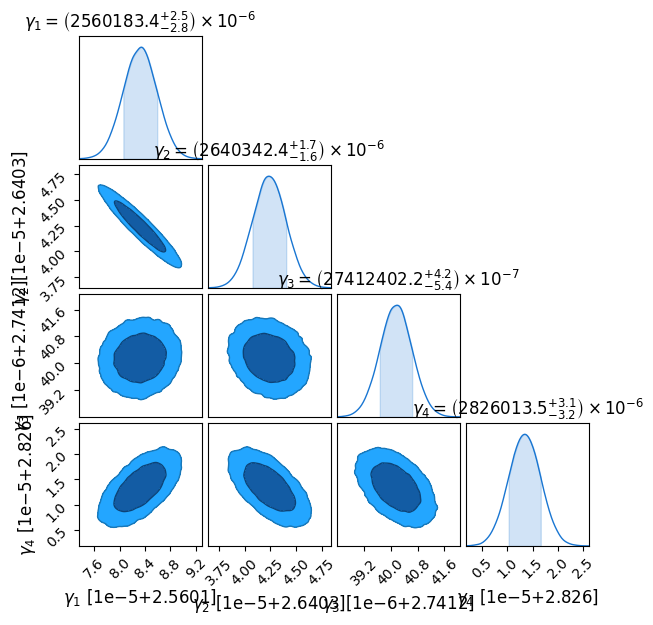

In [49]:
from chainconsumer import ChainConsumer
c=ChainConsumer()
chain = np.load("saves/chain_anstey4regions_gsmalo.npy")
chain = chain[1000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
c.add_chain(chain_flat, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$'])
c.plotter.plot()
plt.show()

In [60]:
c.analysis.get_summary().values()

dict_values([[2.56018058929629, 2.560183402081722, 2.5601859168834644], [2.6403407815525215, 2.640342377382059, 2.6403440606543103], [2.741239674477335, 2.7412402185776723, 2.7412406372648115], [2.826010283416525, 2.826013460874419, 2.826016606820334]])

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_24116/3249436687.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


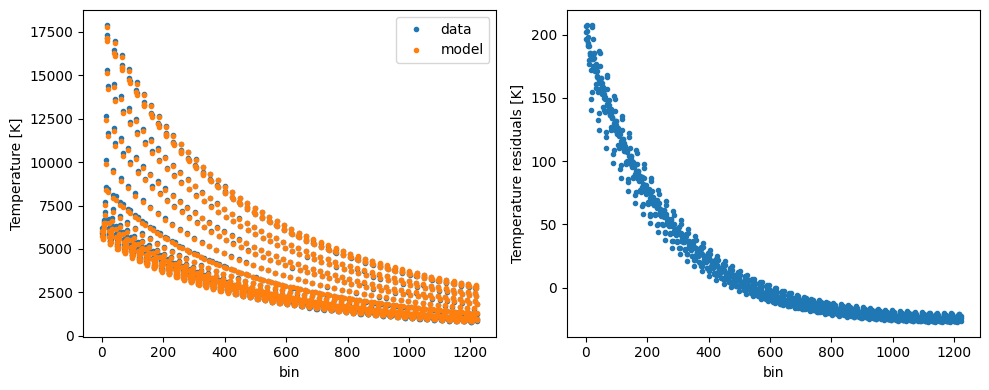

In [67]:
# Generate most-likely data.
theta_mean = np.mean(chain_flat, axis=0)
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_mode = [val[1] for val in analysis_dict.values()]


model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()



### Increase the number of regions to 6!

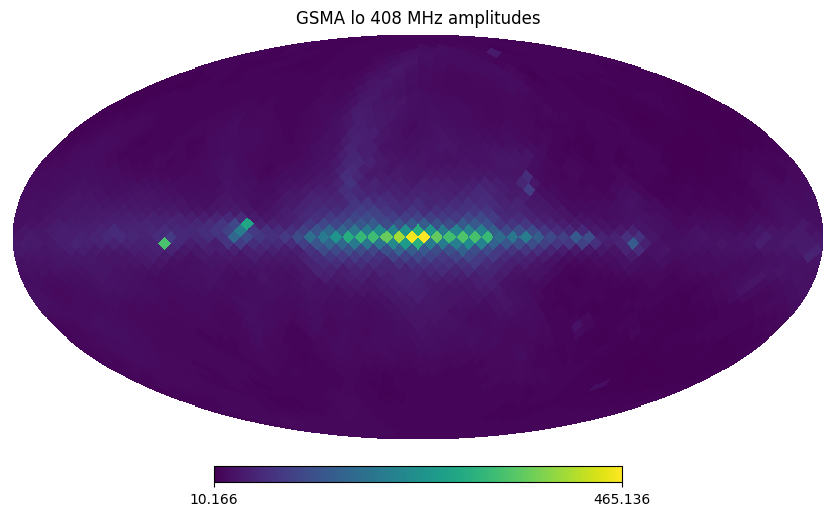

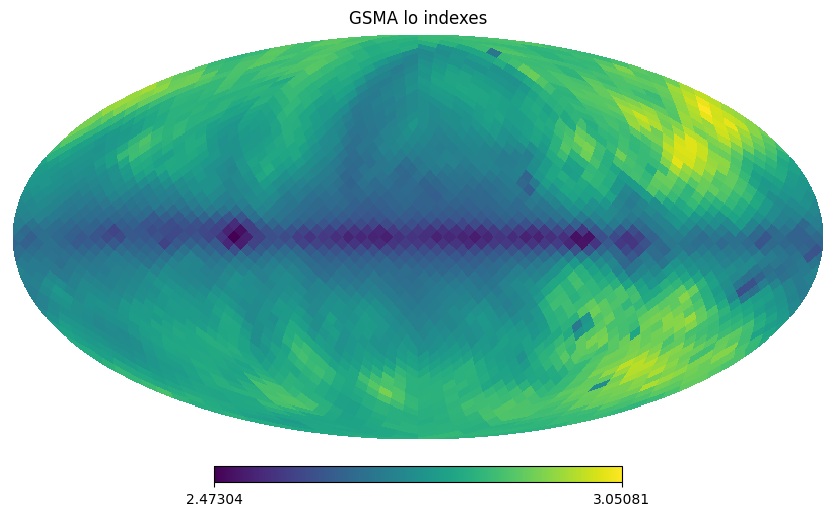

[2.46303511 2.56266409 2.66229307 2.76192205 2.86155103 2.96118001
 3.06080899]
[[2.46303511 2.56266409]
 [2.56266409 2.66229307]
 [2.66229307 2.76192205]
 [2.76192205 2.86155103]
 [2.86155103 2.96118001]
 [2.96118001 3.06080899]]


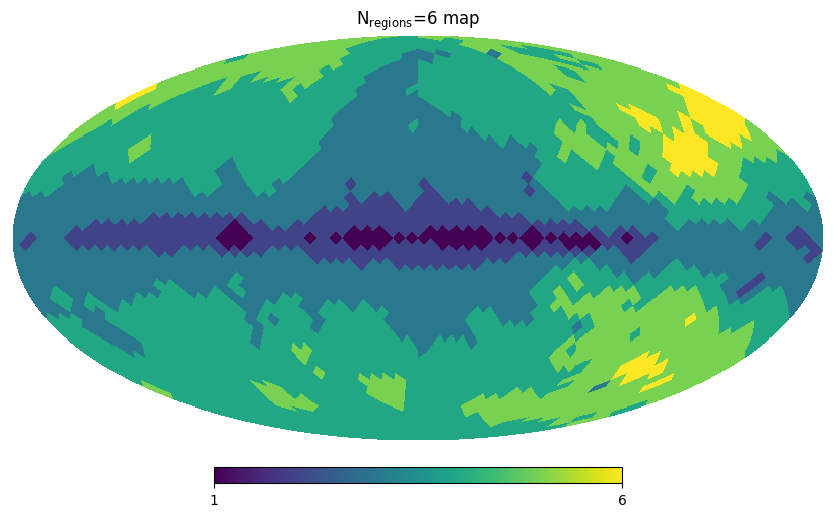

In [29]:
# Split the sky into the Nregions.
indx = np.load("anstey/indexes_16.npy")
hp.mollview(indx[0], title="GSMA lo 408 MHz amplitudes")
plt.show()
hp.mollview(indx[1], title="GSMA lo indexes")
plt.show()

Nregions = 6
max_indx = np.max(indx[1])+0.01
min_indx = np.min(indx[1])-0.01
indx_range = np.linspace(min_indx, max_indx, Nregions+1)
inference_bounds = [(indx_range[i],indx_range[i+1]) for i in range(Nregions)]
inference_bounds = np.array(inference_bounds)
print(indx_range)
print(inference_bounds)

masks = []
for i in range(len(indx_range)-1):
    mask = []
    range_tuple = (indx_range[i], indx_range[i+1])
    for j in range(len(indx[1])):
        if indx[1,j] > range_tuple[0] and indx[1,j] < range_tuple[1]:
            mask.append(j)
    masks.append(mask)
mask_maps = []
for mask in masks:
    mask_map = np.zeros(len(indx[1]))
    mask_map[mask] = 1.
    mask_maps.append(mask_map)
mask_visualisation = np.sum([(i+1)*mask_maps[i] for i in range(Nregions)], axis=0)
hp.mollview(mask_visualisation, title=r"N$_\mathrm{regions}$="+f"{Nregions} map")
plt.show()

# Set up the Nregions model.
model = FM.generate_nregions_pl_forward_model(nuarr=nuarr, masks=mask_maps, observation_mat=mat_A, spherical_harmonic_mat=mat_Y)

# Run inference.
# create a small ball around the MLE the initialize each walker
nwalkers, ndim = 32, len(inference_bounds)
theta_guess = np.array([0.5*(bound[0]+bound[1]) for bound in inference_bounds])
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))



In [82]:
np.mean(chain_flat, axis=0)

array([2.842971  , 2.28942074, 2.66266918, 2.73344628, 2.77715456,
       2.95407823])

In [72]:
# run emcee
Nstep = 10000
err = np.sqrt(noise_covar.diag)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
                                args=(dnoisy.vector, err, model))
_=sampler.run_mcmc(pos, Nstep, progress=True)
#np.save("saves/chain_anstey6regions_gsmalo", sampler.get_chain())  # SAVE THE CHAIN.

100%|██████████| 10000/10000 [26:11<00:00,  6.36it/s]


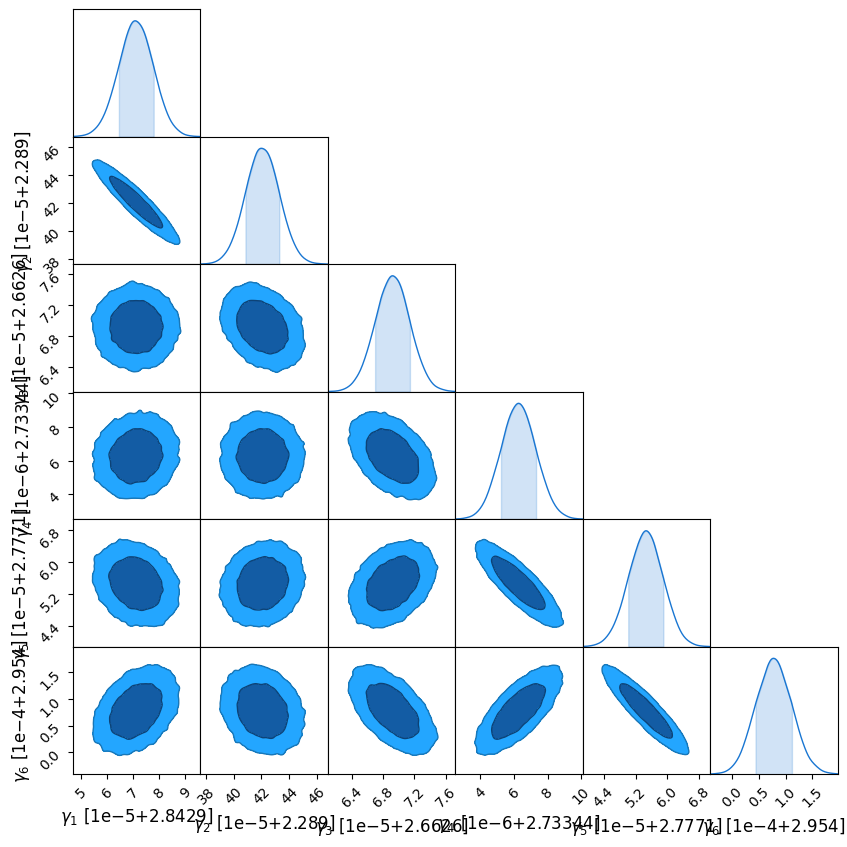

In [81]:
c=ChainConsumer()
chain = np.load("saves/Nregs_pl_gsmalo/6reg_unoise.npy")
chain = chain[2000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
c.add_chain(chain_flat, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$'])
c.plotter.plot()
plt.show()

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_24116/3249436687.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


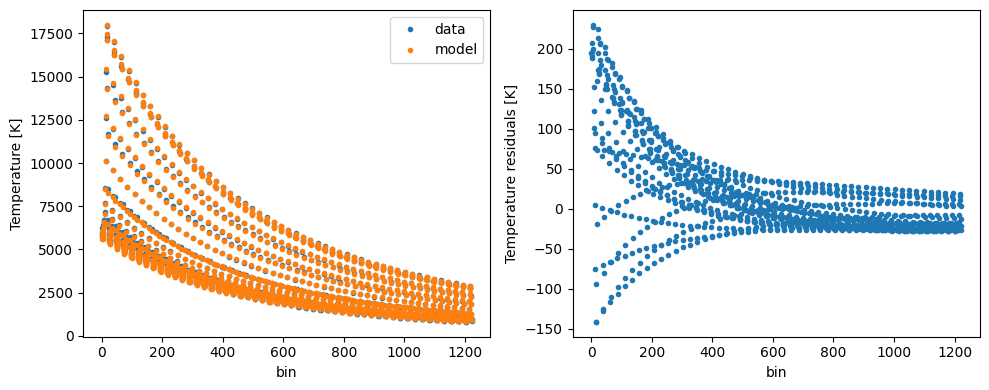

In [74]:
# Generate most-likely data.
theta_mean = np.mean(chain_flat, axis=0)
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_mode = [val[1] for val in analysis_dict.values()]


model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()



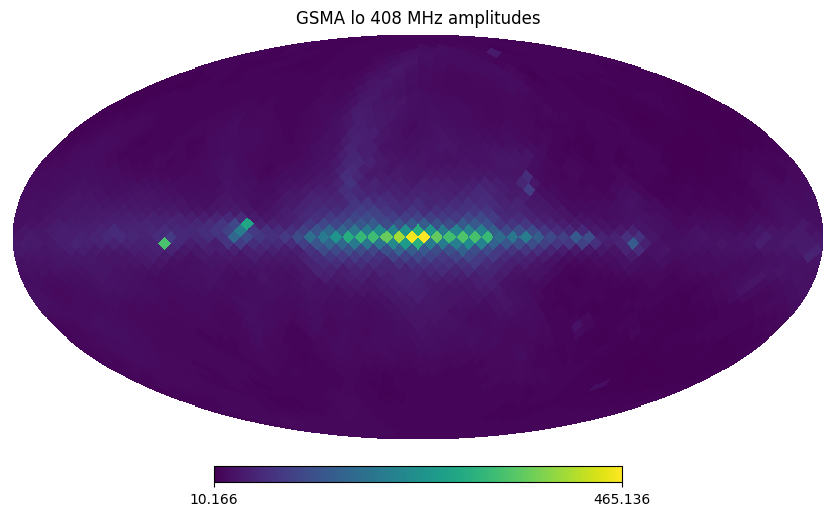

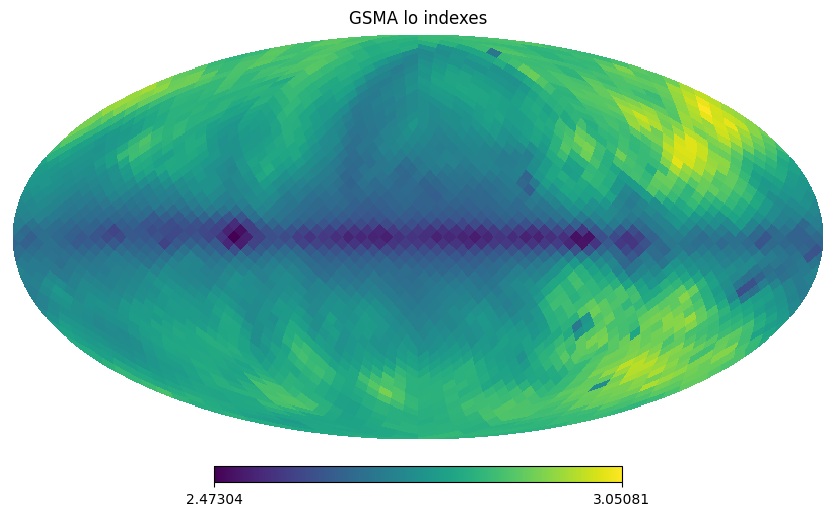

[2.46303511 2.52945443 2.59587375 2.66229307 2.72871239 2.79513171
 2.86155103 2.92797035 2.99438967 3.06080899]
[[2.46303511 2.52945443]
 [2.52945443 2.59587375]
 [2.59587375 2.66229307]
 [2.66229307 2.72871239]
 [2.72871239 2.79513171]
 [2.79513171 2.86155103]
 [2.86155103 2.92797035]
 [2.92797035 2.99438967]
 [2.99438967 3.06080899]]


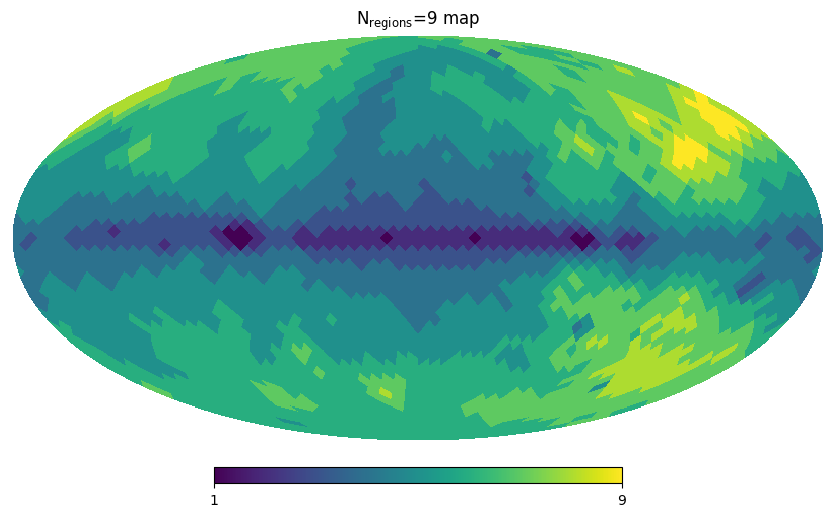

In [6]:
# Split the sky into the Nregions.
indx = np.load("anstey/indexes_16.npy")
hp.mollview(indx[0], title="GSMA lo 408 MHz amplitudes")
plt.show()
hp.mollview(indx[1], title="GSMA lo indexes")
plt.show()

Nregions = 9
max_indx = np.max(indx[1])+0.01
min_indx = np.min(indx[1])-0.01
indx_range = np.linspace(min_indx, max_indx, Nregions+1)
inference_bounds = [(indx_range[i],indx_range[i+1]) for i in range(Nregions)]
inference_bounds = np.array(inference_bounds)
print(indx_range)
print(inference_bounds)

masks = []
for i in range(len(indx_range)-1):
    mask = []
    range_tuple = (indx_range[i], indx_range[i+1])
    for j in range(len(indx[1])):
        if indx[1,j] > range_tuple[0] and indx[1,j] < range_tuple[1]:
            mask.append(j)
    masks.append(mask)
mask_maps = []
for mask in masks:
    mask_map = np.zeros(len(indx[1]))
    mask_map[mask] = 1.
    mask_maps.append(mask_map)
mask_visualisation = np.sum([(i+1)*mask_maps[i] for i in range(Nregions)], axis=0)
hp.mollview(mask_visualisation, title=r"N$_\mathrm{regions}$="+f"{Nregions} map")
plt.show()

# Set up the Nregions model.
model = FM.generate_nregions_pl_forward_model(nuarr=nuarr, masks=mask_maps, observation_mat=mat_A, spherical_harmonic_mat=mat_Y)

# Run inference.
# create a small ball around the MLE the initialize each walker
nwalkers, ndim = 32, len(inference_bounds)
theta_guess = np.array([0.5*(bound[0]+bound[1]) for bound in inference_bounds])
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))
prev_chain = np.load("saves/chain_anstey9regions_gsmalo2.npy")
theta_guess = prev_chain[-1]
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))



In [31]:
# run emcee
import emcee
Nstep = 10000
err = np.sqrt(noise_covar.diag)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
                                args=(dnoisy.vector, err, model))
_=sampler.run_mcmc(pos, Nstep, progress=True)
np.save("saves/chain_anstey9regions_gsmalo3", sampler.get_chain())  # SAVE THE CHAIN.

100%|██████████| 10000/10000 [2:13:23<00:00,  1.25it/s]    


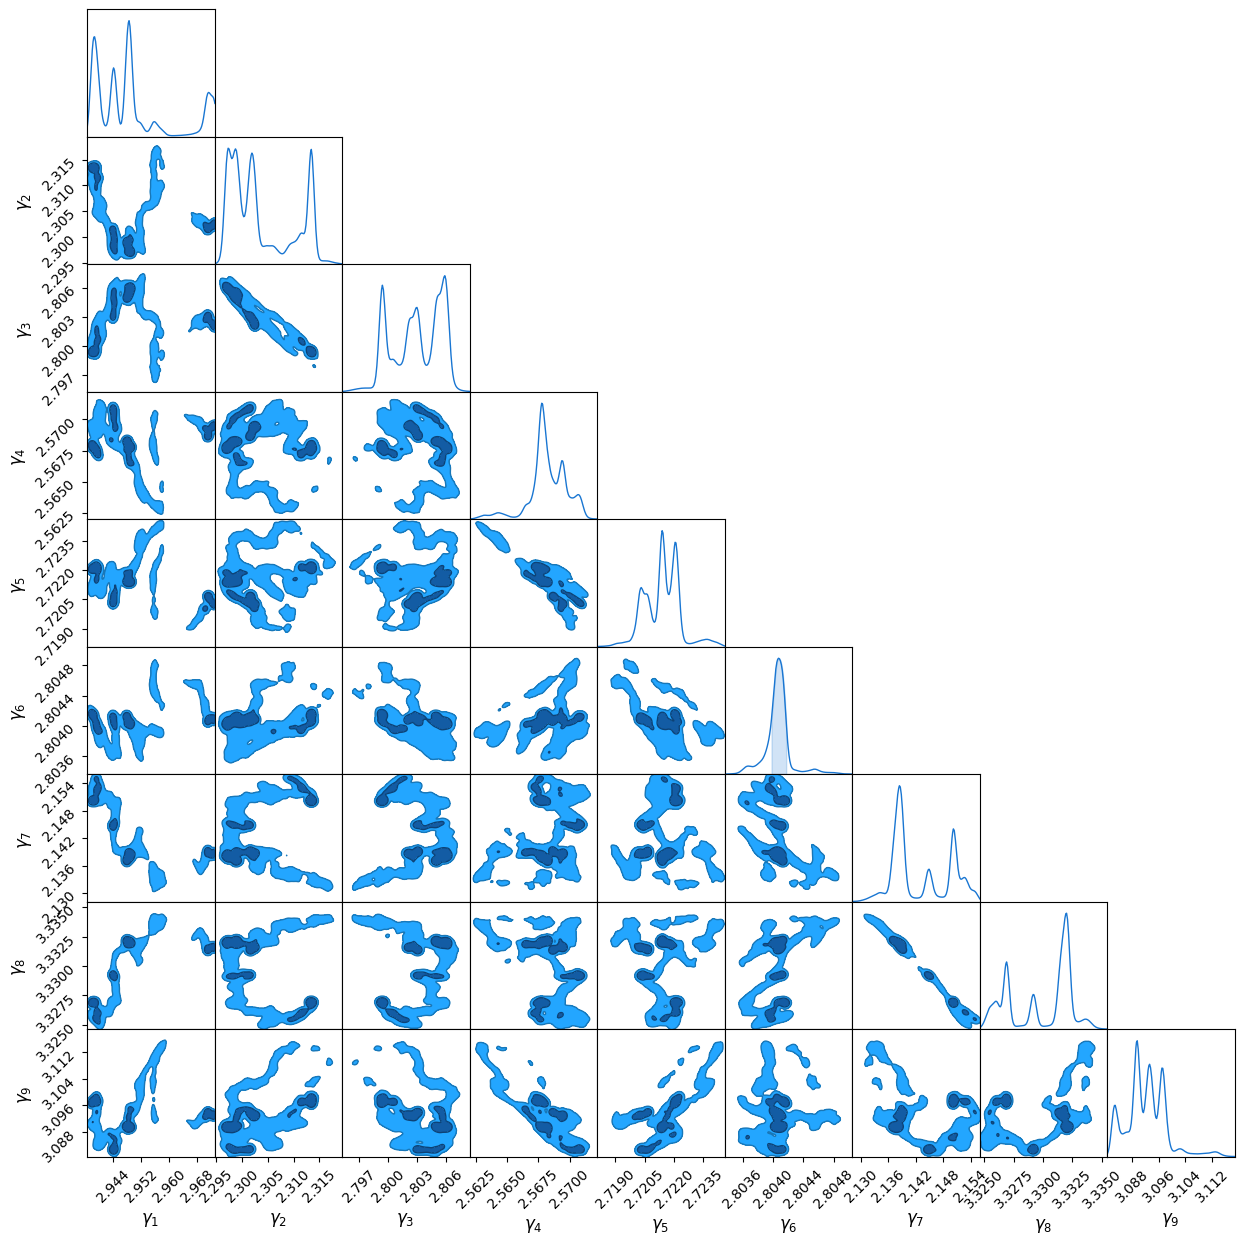

In [32]:
c=ChainConsumer()
chain = np.load("saves/chain_anstey9regions_gsmalo3.npy")
chain = chain[5000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
c.add_chain(chain_flat, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$',r'$\gamma_7$',r'$\gamma_8$',r'$\gamma_9$'])
c.plotter.plot()
plt.show()

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_3141/3249436687.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


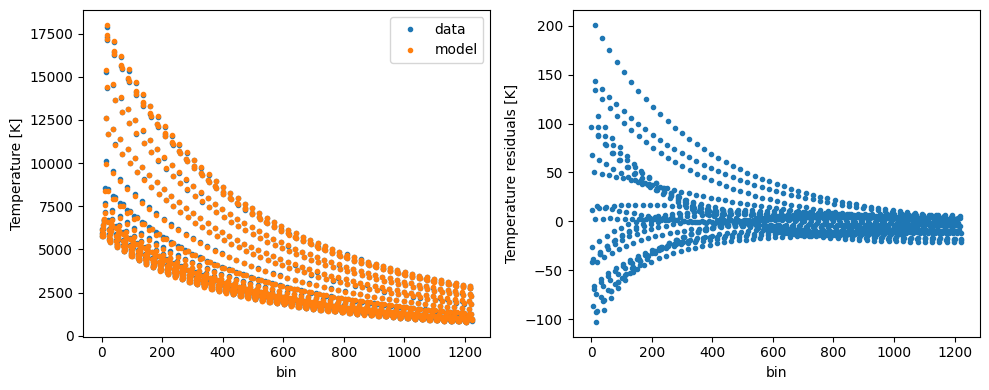

In [33]:
# Generate most-likely data.
theta_mean = np.mean(chain_flat, axis=0)
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_mode = [val[1] for val in analysis_dict.values()]


model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()



In [68]:
chain_flat.shape

(160000, 5)

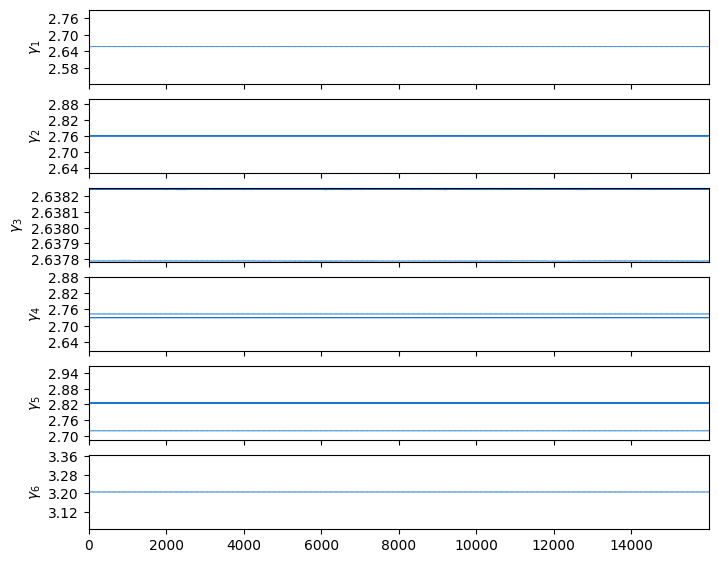

In [117]:
chain = np.load("saves/chain_anstey6regions_gsmalo_speedy.npy")
chain = chain[5000:5500]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
#chain_clean = np.array([elt for elt in chain_flat if elt[2]>2.68])
c=ChainConsumer()
c.add_chain(chain_flat, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$'])
c.plotter.plot_walks()
plt.show()

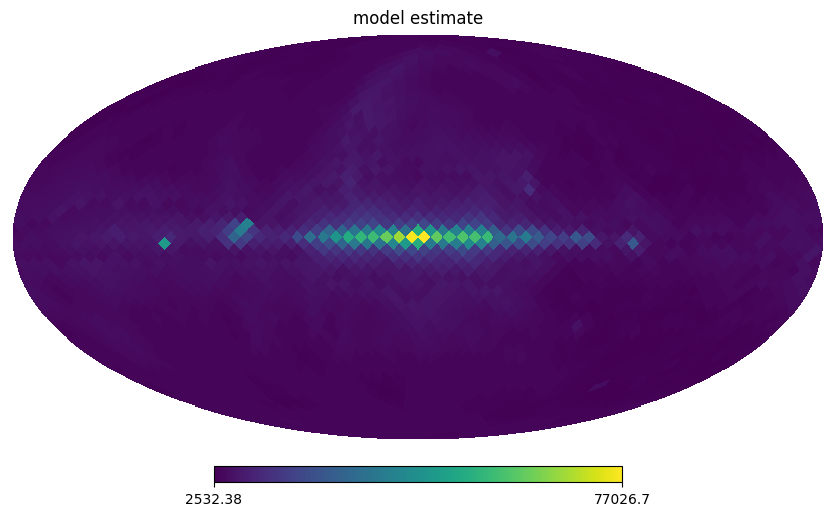

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin


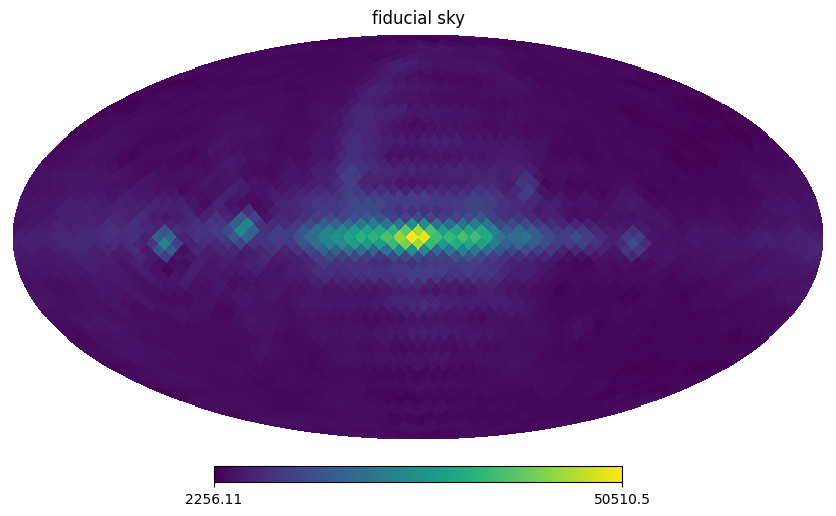

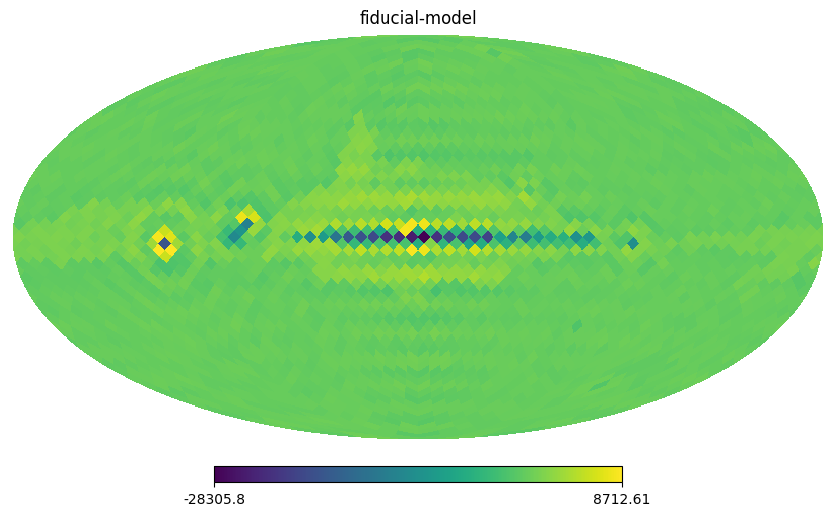

In [106]:
from src.nregions_models import pix_forward_model_pl
theta_mean = np.mean(chain_clean, axis=0)
theta_adjusted = np.array(theta_mean)
#theta_adjusted[-1] = 10
hp.mollview(np.split(pix_forward_model_pl(powers=theta_adjusted, nuarr=nuarr, base_map=indx[0], masks=mask_maps), 51)[10], title='model estimate')
plt.show()
_, gsma_lo = SM.foreground_gsma_alm_nsidelo(nu=60, lmax=32, nside=16, map=True)
hp.mollview(gsma_lo[0], title='fiducial sky')
plt.show()
hp.mollview(gsma_lo[0]-np.split(pix_forward_model_pl(powers=theta_adjusted, nuarr=nuarr, base_map=indx[0], masks=mask_maps), 51)[10], title='fiducial-model')

INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.00

3072 561


INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.00

[2.46303511 2.58258988 2.70214466 2.82169944 2.94125421 3.06080899]
[[2.46303511 2.58258988]
 [2.58258988 2.70214466]
 [2.70214466 2.82169944]
 [2.82169944 2.94125421]
 [2.94125421 3.06080899]]


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_34357/1900910711.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


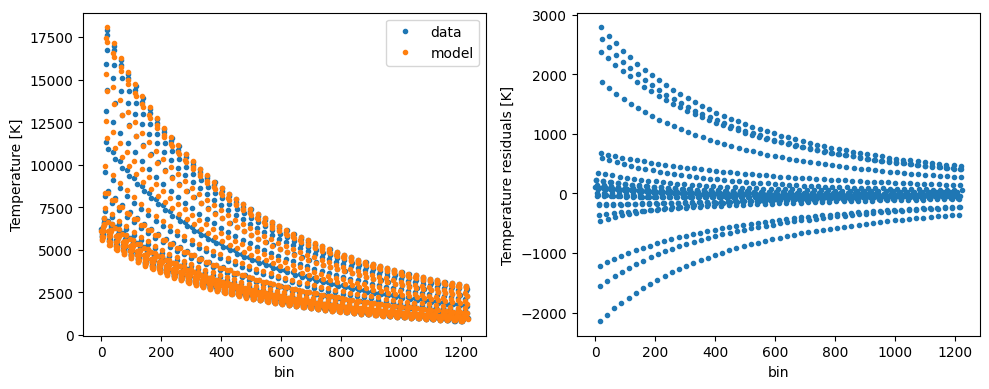

In [109]:
# Generate most-likely data.
theta_mean = np.mean(chain_flat, axis=0)

model = NRI.main(Nregions=5, return_model=True)
model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()

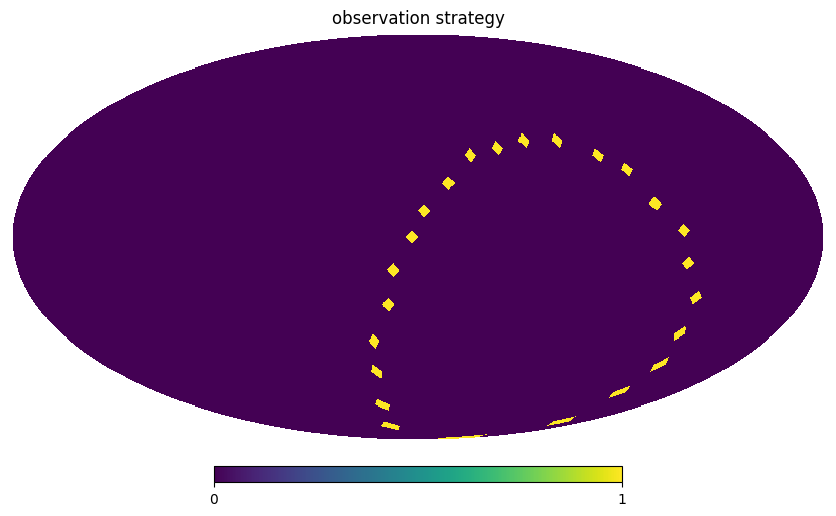

In [60]:
total = np.zeros(3072)
for row in mat_P.block[0]:
    total += row
hp.mollview(total, title='observation strategy')

INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.00

3072 561


INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.00

[2.46303511 2.56266409 2.66229307 2.76192205 2.86155103 2.96118001
 3.06080899]
[[2.46303511 2.56266409]
 [2.56266409 2.66229307]
 [2.66229307 2.76192205]
 [2.76192205 2.86155103]
 [2.86155103 2.96118001]
 [2.96118001 3.06080899]]


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_34357/1120448979.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


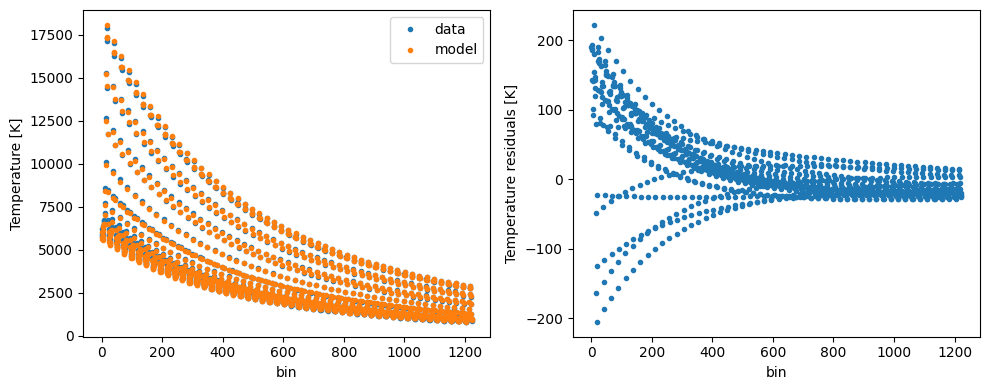

In [27]:
# Generate most-likely data.
theta_mean = np.mean(chain_flat, axis=0)
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_mode = [val[1] for val in analysis_dict.values()]

model = NRI.main(Nregions=6, return_model=True)
model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()



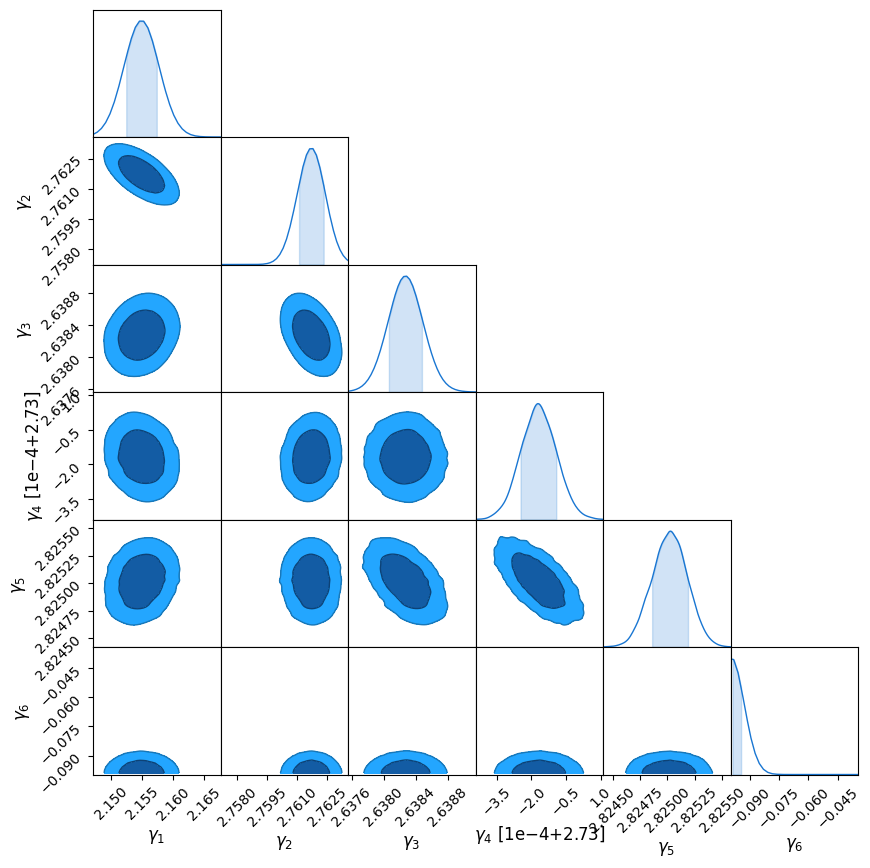

In [5]:
chain = np.load("saves/Nregs_pl_gsmalo/6reg_radnoise.npy")
c=ChainConsumer()
chain = chain[7000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
chain_clean = np.array([elt for elt in chain_flat if elt[0]<2.25])
c.add_chain(chain_clean, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$'])
c.plotter.plot()
plt.show()

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm

3072 561


INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.0

[2.46303511 2.56266409 2.66229307 2.76192205 2.86155103 2.96118001
 3.06080899]
[[2.46303511 2.56266409]
 [2.56266409 2.66229307]
 [2.66229307 2.76192205]
 [2.76192205 2.86155103]
 [2.86155103 2.96118001]
 [2.96118001 3.06080899]]


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_3518/3118386619.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


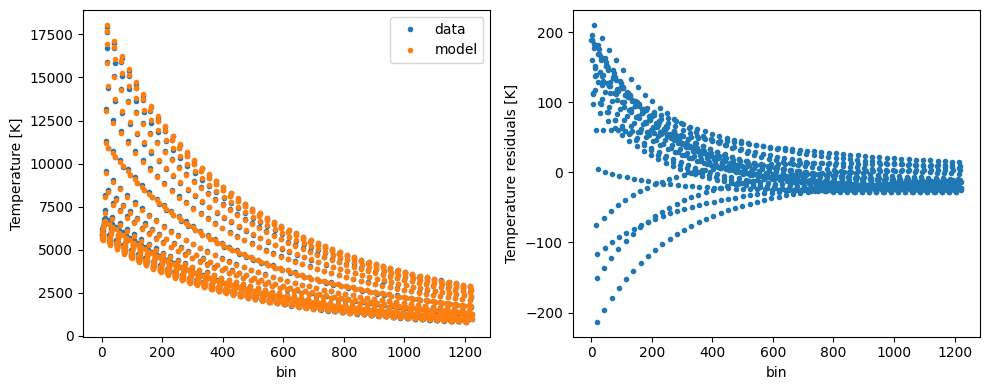

In [7]:
# Generate most-likely data.
import nregions_inference as NRI
theta_mean = np.mean(chain_clean, axis=0)
analysis_dict = c.analysis.get_summary(squeeze=True)
theta_mode = [val[1] for val in analysis_dict.values()]

model = NRI.main(Nregions=6, return_model=True)
model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()

In [8]:
theta_mean

array([ 2.15492554,  2.76171547,  2.63827476,  2.72983147,  2.82501959,
       -0.09935181])

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_3518/1254632917.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


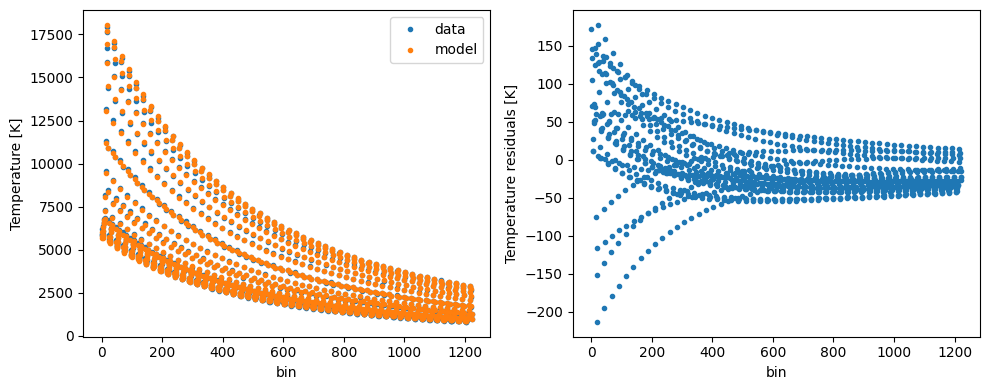

In [13]:
theta_adjusted = np.array(theta_mean)
theta_adjusted[-1]=2.5
model_temps = model(theta=theta_adjusted)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()

In [1]:
from chainconsumer import ChainConsumer
import numpy as np
import matplotlib.pyplot as plt

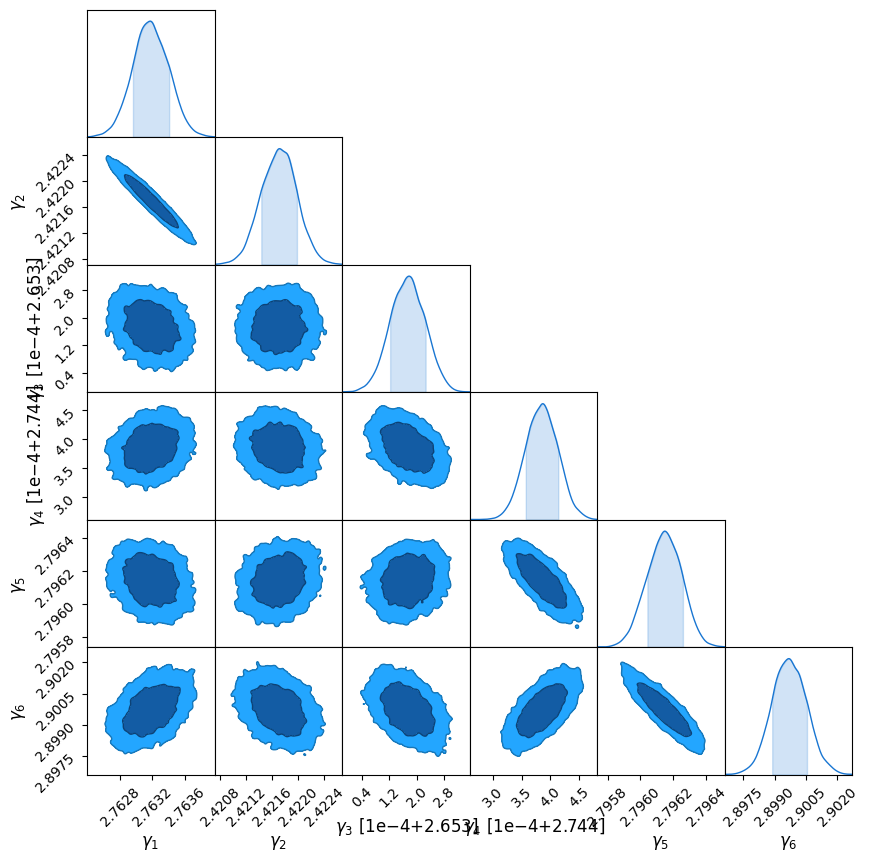

In [2]:
chain = np.load("saves/Nregs_pl_gsmalo/6reg_unoise.npy")
c=ChainConsumer()
chain = chain[7000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
chain_clean = np.array([elt for elt in chain_flat if elt[0]>2.6])
c.add_chain(chain_clean, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$'])
c.plotter.plot()
plt.show()

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_3518/2142496377.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


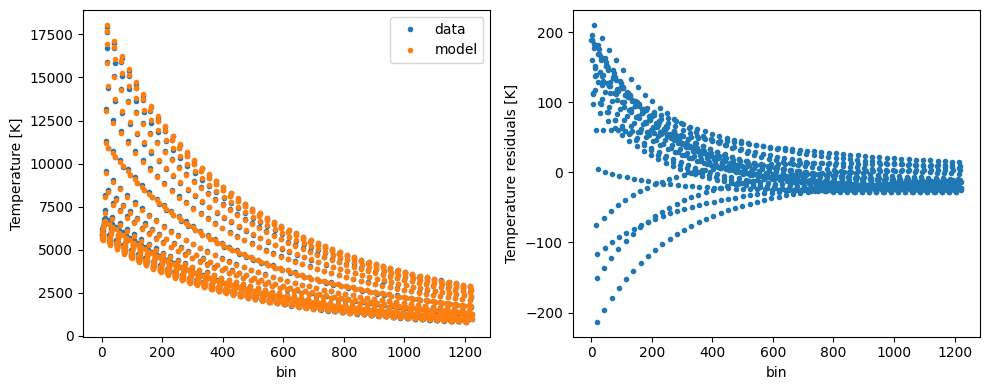

In [16]:
theta_adjusted = np.array(theta_mean)
theta_adjusted[-1]=2.5
model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()

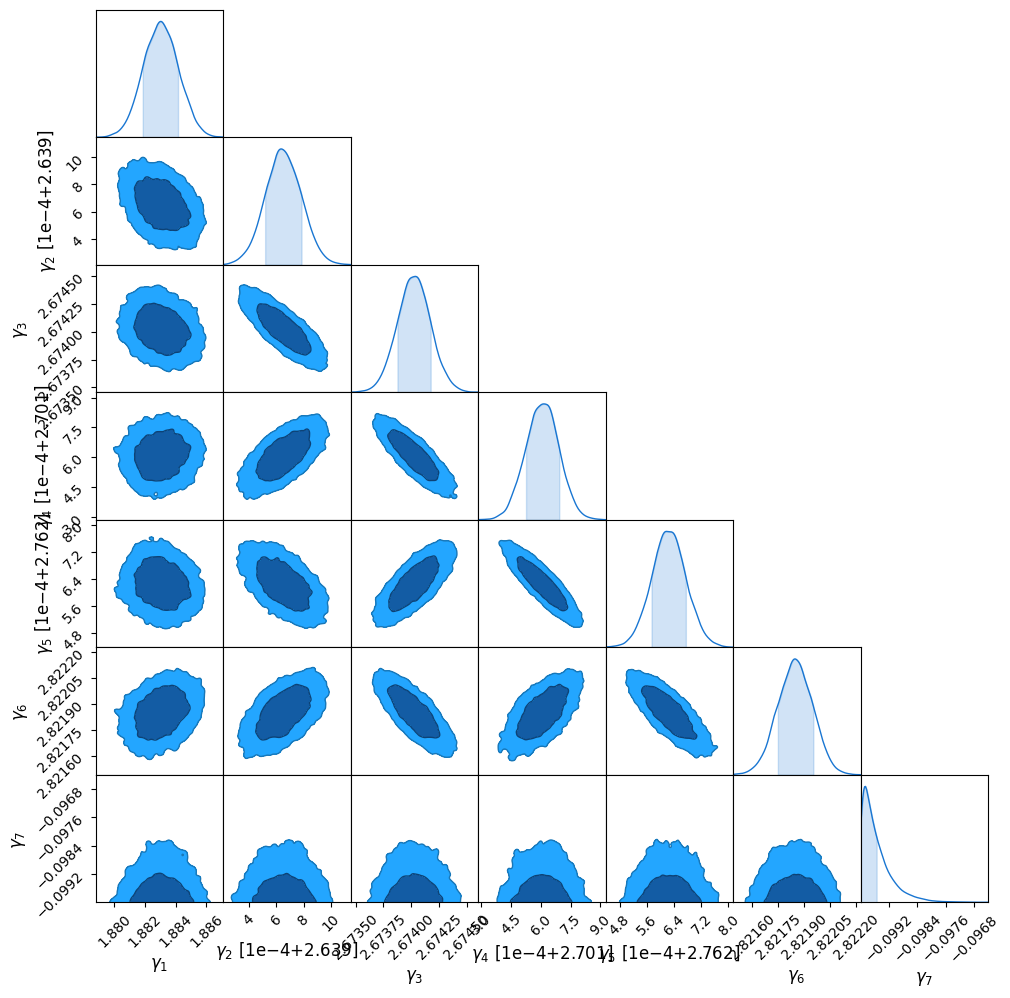

In [18]:
chain = np.load("saves/Nregs_pl_gsmalo/7reg_unoise.npy")
c=ChainConsumer()
chain = chain[7000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
chain_clean = chain_flat#np.array([elt for elt in chain_flat if elt[0]>2.6])
c.add_chain(chain_clean, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$',r'$\gamma_7$'])
c.plotter.plot()
plt.show()

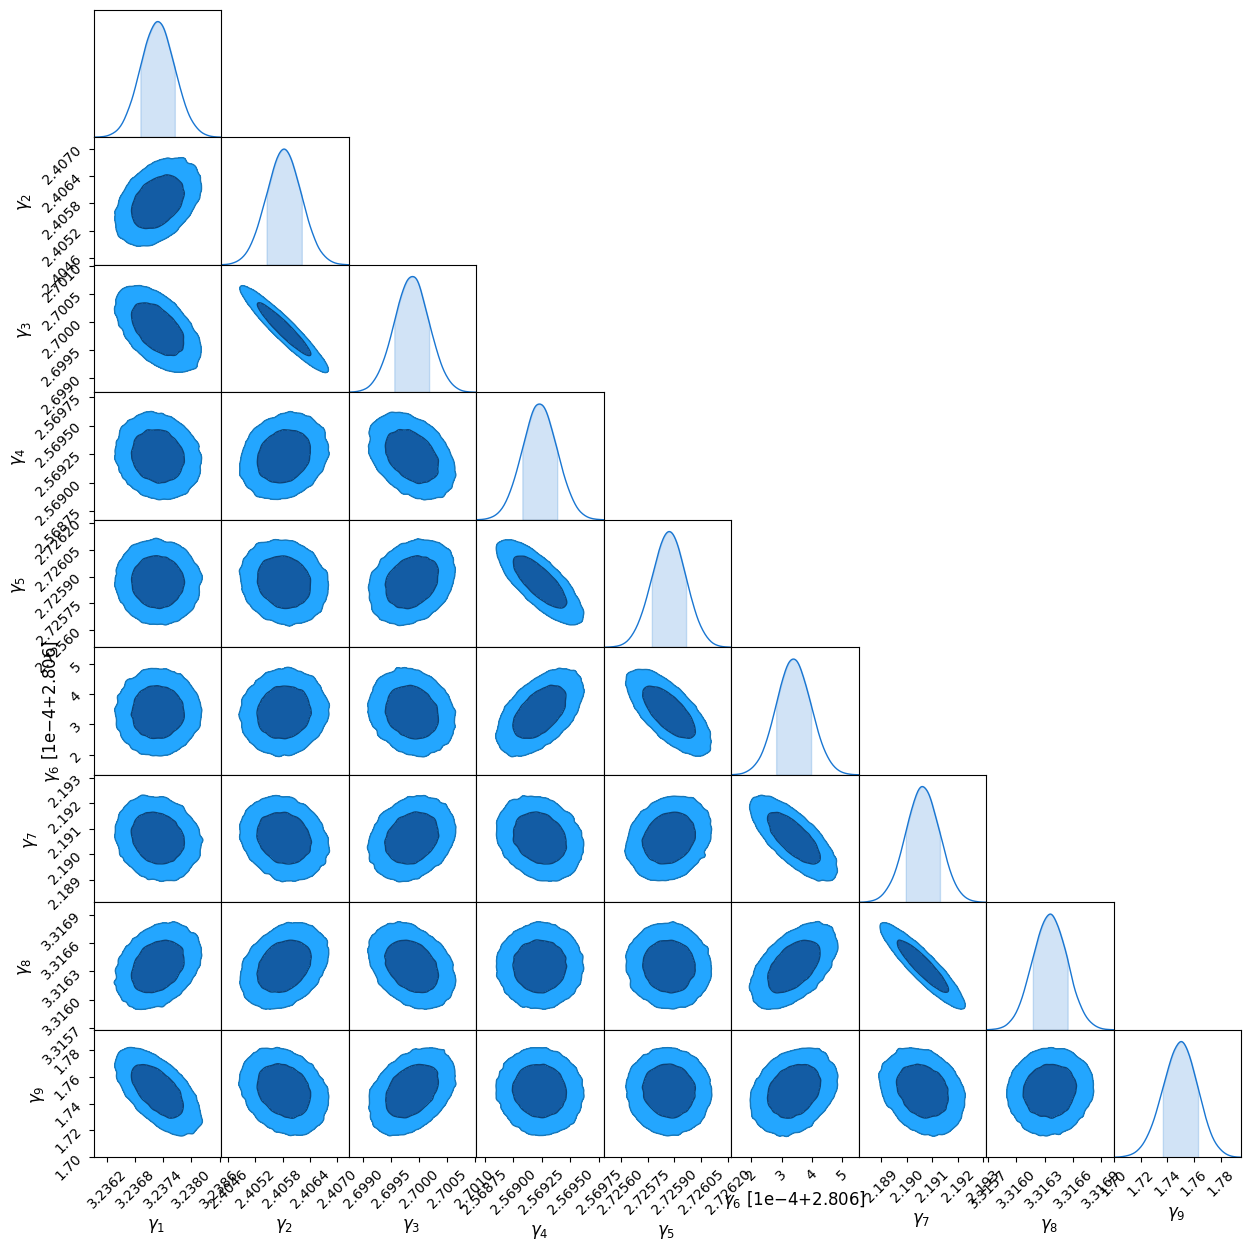

In [27]:
chain = np.load("saves/Nregs_pl_gsmalo/9reg_unoise_1.npy")
c=ChainConsumer()
chain = chain[10000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
chain_clean = chain_flat#np.array([elt for elt in chain_flat if elt[0]>2.6])
c.add_chain(chain_clean, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$',r'$\gamma_7$',r'$\gamma_8$',r'$\gamma_9$'])
c.plotter.plot()
plt.show()

INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.00

3072 561


INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.00

[2.46303511 2.52945443 2.59587375 2.66229307 2.72871239 2.79513171
 2.86155103 2.92797035 2.99438967 3.06080899]
[[2.46303511 2.52945443]
 [2.52945443 2.59587375]
 [2.59587375 2.66229307]
 [2.66229307 2.72871239]
 [2.72871239 2.79513171]
 [2.79513171 2.86155103]
 [2.86155103 2.92797035]
 [2.92797035 2.99438967]
 [2.99438967 3.06080899]]


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_5672/1801861328.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[6208.70213894 5935.58121354 5830.94955861 5773.19383915 5891.82542541
 6081.57252745 6348.73596271 6545.01639286 6606.17266894 6779.85836551]
[6103.57359804 5873.80248675 5843.84286612 5825.93609716 5964.68718476
 6121.73406855 6376.11419796 6597.08949373 6661.38994827 6850.37248158]


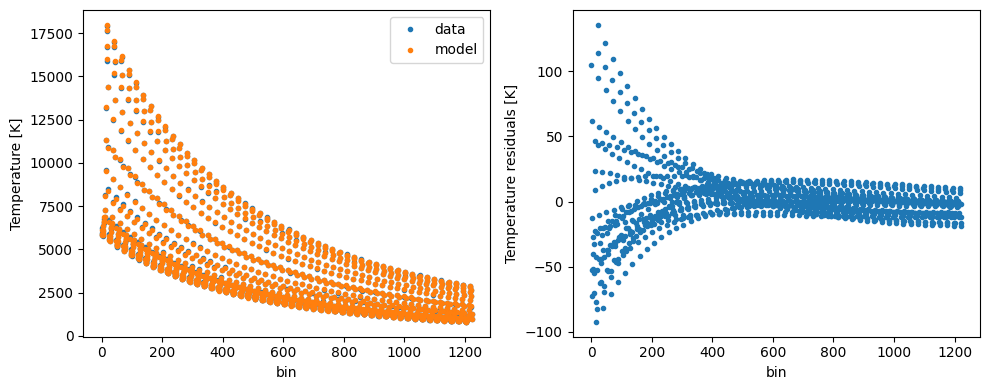

In [29]:
# Generate most-likely data.
import nregions_inference as NRI
theta_mean = np.mean(chain_clean, axis=0)

model = NRI.main(Nregions=9, return_model=True)
model_temps_NUnoise = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()
print(dnoisy.vector[:10])
print(model_temps[:10])

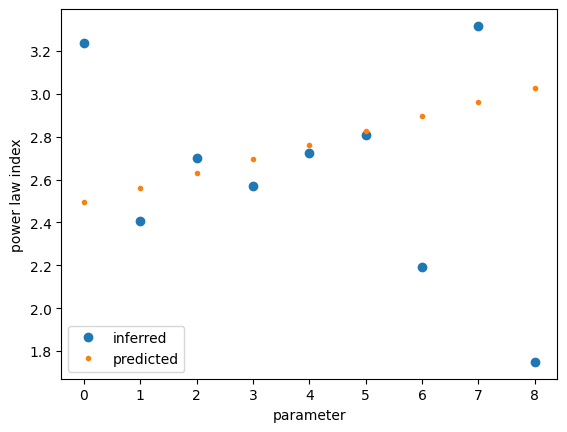

In [14]:
probable_theta = np.array([0.5*(bound[0]+bound[1]) for bound in inference_bounds])
plt.plot(theta_mean, 'o', label='inferred')
plt.plot(probable_theta, '.', label='predicted')
plt.xlabel("parameter")
plt.ylabel("power law index")
plt.legend()

/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_5672/4096839345.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


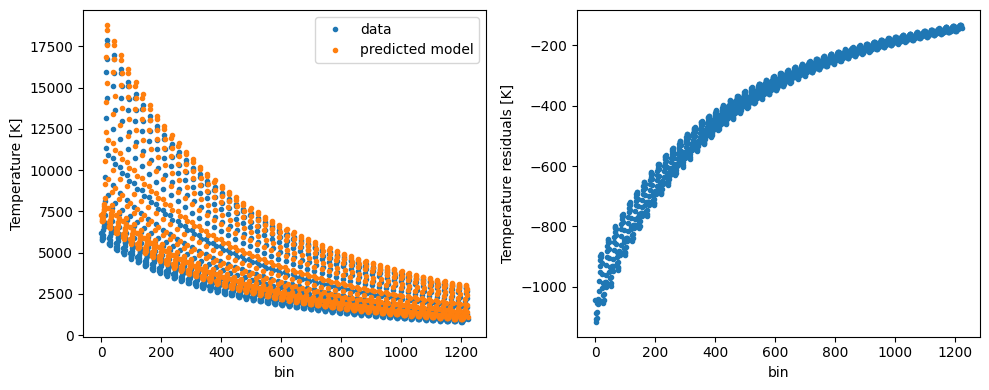

In [13]:
probable_model = model(theta=probable_theta)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(probable_model, '.', label='predicted model')
ax[1].plot(dnoisy.vector-probable_model, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()

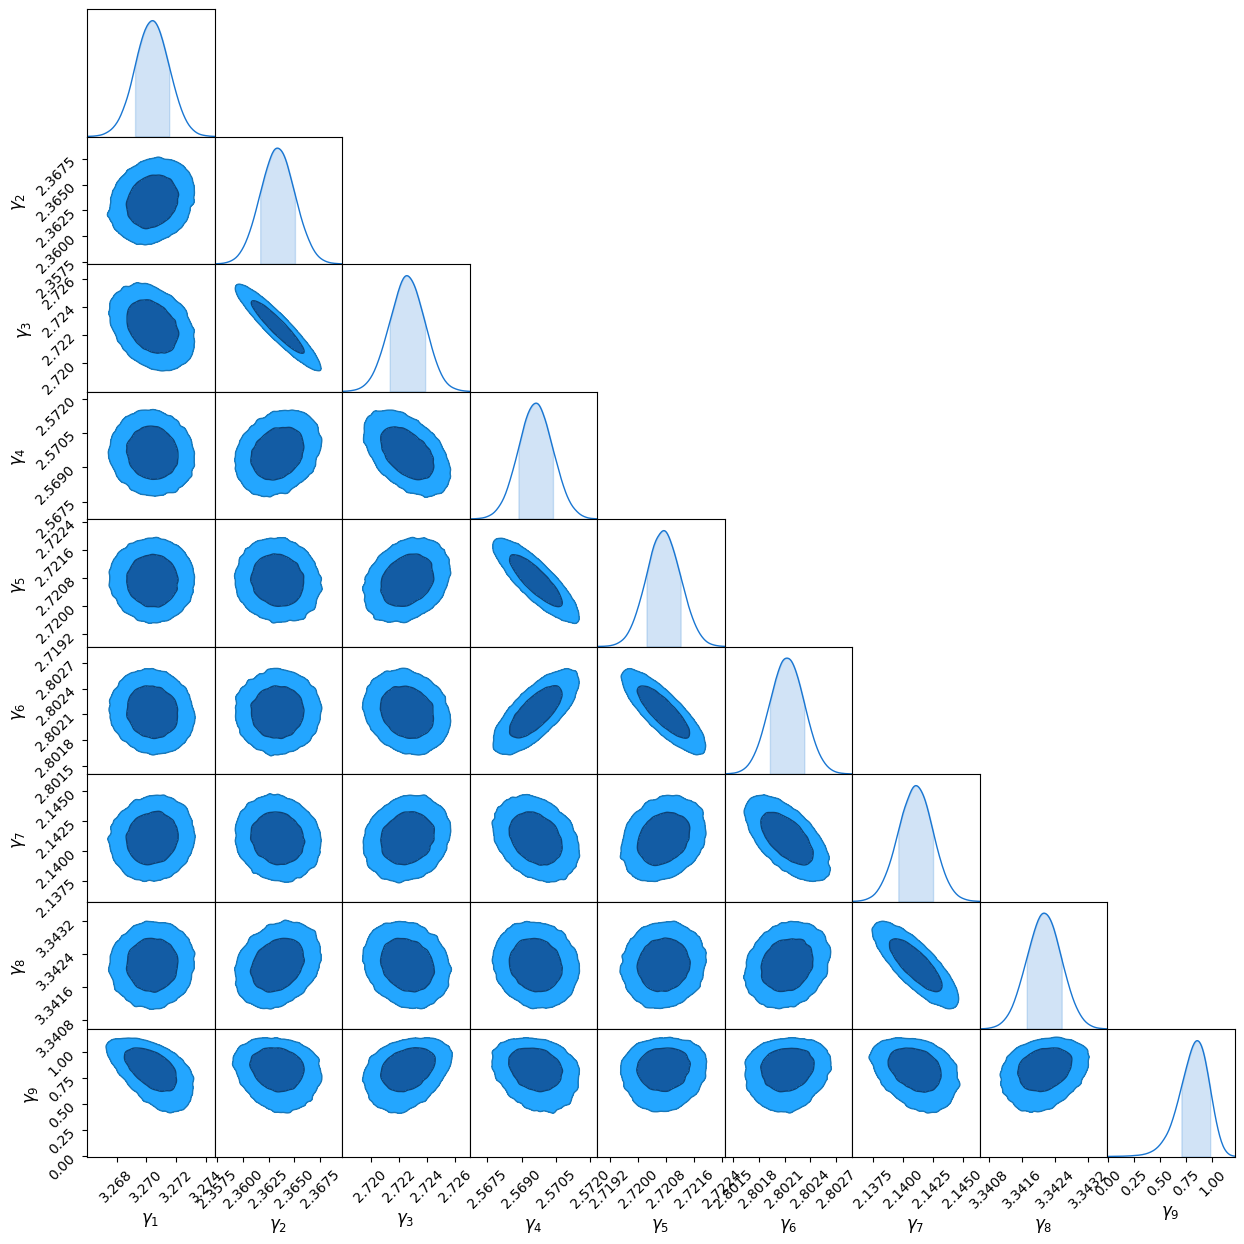

In [19]:
chain = np.load("saves/Nregs_pl_gsmalo/9reg_radnoise.npy")
c=ChainConsumer()
chain = chain[10000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
chain_clean = chain_flat#np.array([elt for elt in chain_flat if elt[0]>2.6])
c.add_chain(chain_clean, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$',r'$\gamma_7$',r'$\gamma_8$',r'$\gamma_9$'])
c.plotter.plot()
plt.show()

In [20]:
np.mean(chain_clean, axis=0)

array([3.27039404, 2.3633859 , 2.72260374, 2.56962063, 2.72073385,
       2.80212873, 2.14107269, 3.34214068, 0.81725777])

INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.00

3072 561


INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.000000 arcmin
INFO:healpy:Sigma is 0.000000 arcmin (0.000000 rad) 
INFO:healpy:-> fwhm is 0.00

[2.46303511 2.52945443 2.59587375 2.66229307 2.72871239 2.79513171
 2.86155103 2.92797035 2.99438967 3.06080899]
[[2.46303511 2.52945443]
 [2.52945443 2.59587375]
 [2.59587375 2.66229307]
 [2.66229307 2.72871239]
 [2.72871239 2.79513171]
 [2.79513171 2.86155103]
 [2.86155103 2.92797035]
 [2.92797035 2.99438967]
 [2.99438967 3.06080899]]


/var/folders/8t/41nx33mx3zg8qlw9n3yg7_cc0000gn/T/ipykernel_5672/1770620442.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


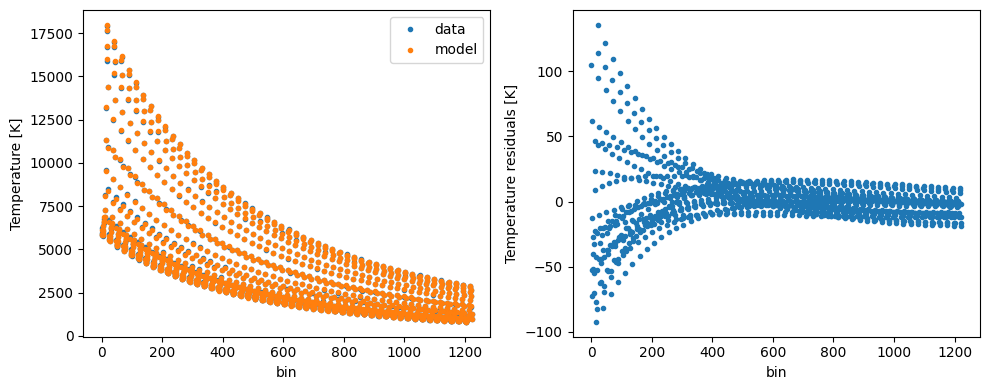

In [21]:
# Generate most-likely data.
theta_mean = np.mean(chain_clean, axis=0)

model = NRI.main(Nregions=9, return_model=True)
model_temps = model(theta=theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dnoisy.vector, '.', label='data')
ax[0].plot(model_temps, '.', label='model')
ax[1].plot(dnoisy.vector-model_temps, '.')
ax[0].set_xlabel('bin')
ax[1].set_xlabel('bin')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature residuals [K]')
ax[0].legend()
fig.tight_layout()
fig.show()

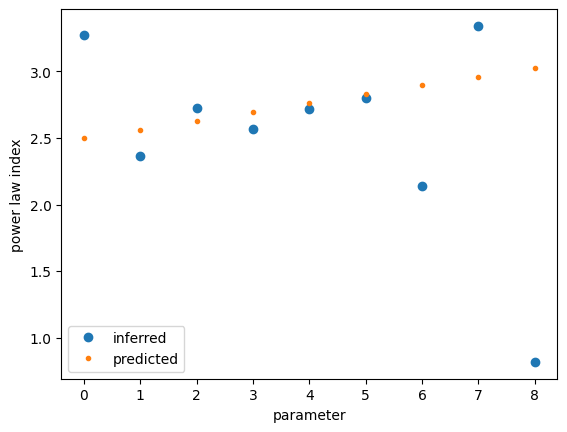

In [22]:
probable_theta = np.array([0.5*(bound[0]+bound[1]) for bound in inference_bounds])
plt.plot(theta_mean, 'o', label='inferred')
plt.plot(probable_theta, '.', label='predicted')
plt.xlabel("parameter")
plt.ylabel("power law index")
plt.legend()

In [9]:
import src.forward_model as FM
reload(FM)

<module 'src.forward_model' from '/Users/yordani/Documents/boosted_compass/matrix-observer/src/forward_model.py'>

In [10]:
mod=FM.genopt_nregions_cm21_pl_forward_model(nuarr, mask_maps, mat_A, mat_Y)

In [11]:
data = mod(theta=np.array([0,0,0,0, -10, 70, 5]))

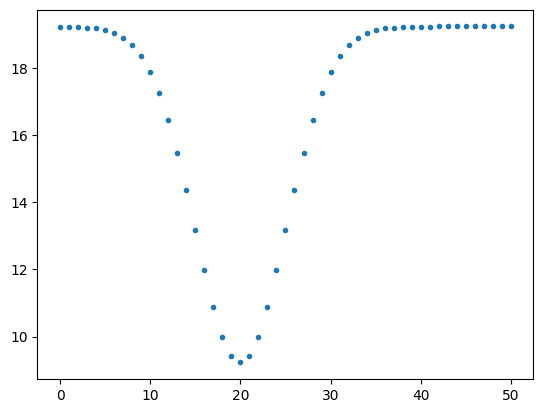

In [12]:
plt.plot(data[::24], '.')

In [13]:
modfg=FM.genopt_nregions_pl_forward_model(nuarr, mask_maps, mat_A, mat_Y)

In [14]:
datafg = modfg(theta=np.array([0,0,0,0]))

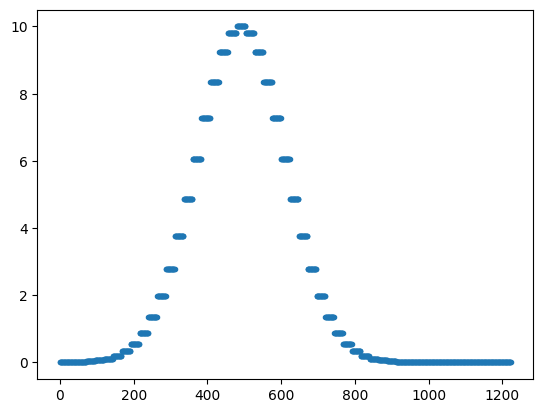

In [15]:
plt.plot(datafg-data, '.')


# 21-cm inference time baybeh!

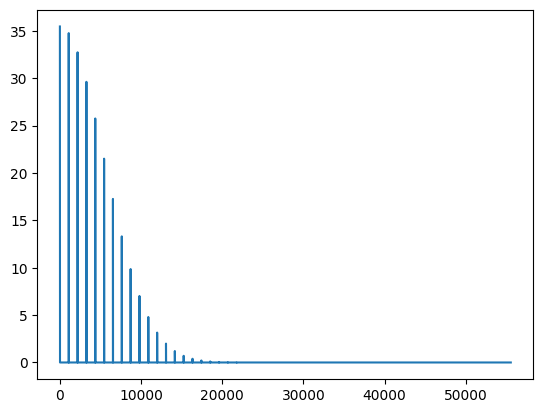

In [16]:
reload(SM)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=(10, 50, 5))
plt.plot(cm21_alm)

In [17]:
mat_Y@cm21_alm

(3072,) x 51 BlockVector

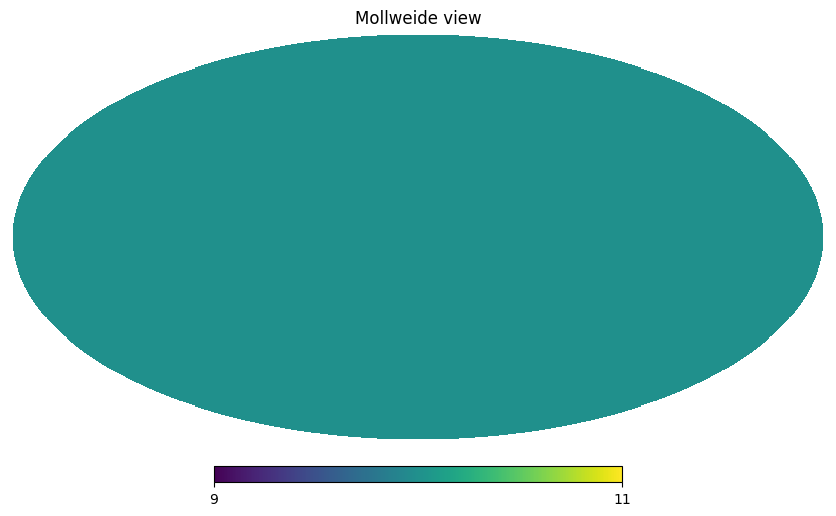

In [18]:
hp.mollview(map=(mat_Y@cm21_alm).block[0])

In [19]:
# Forward model the fiducial degraded GSMA.
Nfreq = 51
nuarr = np.linspace(50,100,51)
lmax = 32
nside = 16
npix = hp.nside2npix(nside)
narrow_cosbeam = lambda x: BF.beam_cos(x, theta0=0.8)
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=(-1000,80,5))

times = np.linspace(0,24,24, endpoint=False)
mat_A, (mat_G, mat_P, mat_Y, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_multifreq(nuarr, nside, lmax, Ntau=len(times), times=times, beam_use=narrow_cosbeam, return_mat=True)

d = mat_A@(fg_alm+cm21_alm)
dnoisy, noise_covar = SM.add_noise(temps=d, dnu=1, Ntau=npix, t_int=1e4)

3072 561


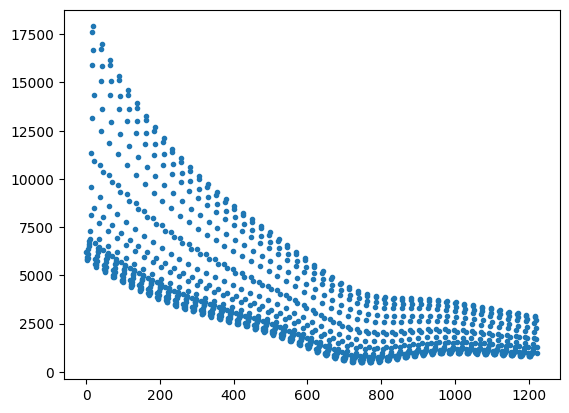

In [21]:
plt.plot(dnoisy.vector, '.')
plt.show()

In [23]:
#4 region inference.
import nregions_inference as NRI
mod = FM.genopt_nregions_cm21_pl_forward_model(nuarr, mask_maps, mat_A, mat_Y)

In [34]:
inference_bounds

array([[ 2.46303511e+00,  2.61247858e+00],
       [ 2.61247858e+00,  2.76192205e+00],
       [ 2.76192205e+00,  2.91136552e+00],
       [ 2.91136552e+00,  3.06080899e+00],
       [-1.50000000e+03, -5.00000000e+02],
       [ 7.00000000e+01,  9.00000000e+01],
       [ 1.00000000e+00,  1.00000000e+01]])

In [51]:
priors

[[-0.1, 5.0],
 [-0.1, 5.0],
 [-0.1, 5.0],
 [-0.1, 5.0],
 [-0.1, 5.0],
 [-0.1, 5.0],
 [-0.1, 5.0],
 [-1500, -500],
 [70, 90],
 [1, 10]]

In [52]:
from emcee import EnsembleSampler
mask_maps, inference_bounds = NRI.mask_split(Nregions=4)
inference_bounds = np.append(inference_bounds, [[-1500,-500],[70,90],[1,10]], axis=0)

# create a small ball around the MLE the initialize each walker
nwalkers, ndim = 32, len(inference_bounds)
theta_guess = np.array([0.5*(bound[0]+bound[1]) for bound in inference_bounds])
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))
priors = [[-0.1, 5.0]]*ndim
priors += [[-1500,-500],[70,90],[1,10]]
priors = np.array(priors)

# run emcee
err = np.sqrt(noise_covar.diag)
sampler = EnsembleSampler(nwalkers, ndim, NRI.log_posterior, 
                    args=(dnoisy.vector, err, mod, priors))
_=sampler.run_mcmc(pos, 10000, progress=True)
np.save(f"saves/Nregs_pl_gsmalo_cm21mon/4reg", sampler.get_chain())

emcee: Exception while calling your likelihood function:
  params: [    2.53801351     2.68755718     2.8365605      2.98626652
 -1000.13067324    79.98755502     5.49980397]
  args: (array([6208.70212369, 5935.5811983 , 5830.94954337, ..., 1683.19623698,
       1262.76434478,  958.77950924]), array([0.05735411, 0.05483005, 0.05386386, ..., 0.01554871, 0.01166489,
       0.00885687]), <function genopt_nregions_cm21_pl_forward_model.<locals>.model at 0x1347a1b40>, array([[-1.0e-01,  5.0e+00],
       [-1.0e-01,  5.0e+00],
       [-1.0e-01,  5.0e+00],
       [-1.0e-01,  5.0e+00],
       [-1.0e-01,  5.0e+00],
       [-1.0e-01,  5.0e+00],
       [-1.0e-01,  5.0e+00],
       [-1.5e+03, -5.0e+02],
       [ 7.0e+01,  9.0e+01],
       [ 1.0e+00,  1.0e+01]]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/yordani/Documents/boosted_compass/matrix-observer/venv_mat/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/yordani/Documents/boosted_compass/matrix-observer/nregions_inference.py", line 115, in log_posterior
    lp = log_prior(theta, prior_range)
  File "/Users/yordani/Documents/boosted_compass/matrix-observer/nregions_inference.py", line 105, in log_prior
    lower =  theta > prior_range[:,0]
ValueError: operands could not be broadcast together with shapes (7,) (10,) 


ValueError: operands could not be broadcast together with shapes (7,) (10,) 

In [28]:
chain = np.load("saves/Nregs_pl_gsmalo_cm21mon/4reg.npy")
c=ChainConsumer()
chain = chain[10000:]  # Burn-in.
ch_sh = np.shape(chain)
chain_flat = np.reshape(chain, (ch_sh[0]*ch_sh[1], ch_sh[2]))  # Flatten chain.
chain_clean = chain_flat#np.array([elt for elt in chain_flat if elt[0]>2.6])
c.add_chain(chain_clean, parameters=[r'$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$',r'$\gamma_6$',r'$\gamma_7$',r'$\gamma_8$',r'$\gamma_9$'])
c.plotter.plot()
plt.show()

AssertionError: Have only 4 columns in chain, but have been given 9 parameters names! Please double check this.